In [144]:
import torch
from torch_geometric.data import Data
import numpy as np
import pylab as pl

In [12]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long) # Conecctions
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)  #features

data = Data(x=x, edge_index=edge_index)

In [13]:
data

Data(edge_index=[2, 4], x=[3, 1])

In [14]:
print(data.keys, end='\n\n')

print(data['x'], end='\n\n')

for key, item in data:
    print(f'{key} found in data')

'edge_attr' in data

['x', 'edge_index']

tensor([[-1.],
        [ 0.],
        [ 1.]])

edge_index found in data
x found in data


False

In [15]:
data.num_nodes # number of nodes

3

In [16]:
data.num_edges # number of conections bidirected

4

In [17]:
data.num_node_features # number of features 

1

In [18]:
data.contains_isolated_nodes() # is isolated nodes?

False

In [20]:
data.contains_self_loops() # ?

False

In [21]:
data.is_directed() # ?

False

In [24]:
data

Data(edge_index=[2, 4], x=[3, 1])

In [86]:
edge_index2 = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long) # Conecctions
x2 = torch.tensor([[-1,1], [0,1], [1,2]], dtype=torch.float)  #features

data2 = Data(x=x2, edge_index=edge_index2)
data2

Data(edge_index=[2, 4], x=[3, 2])

In [88]:
data2.edge_index

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])

In [89]:
data2.x

tensor([[-1.,  1.],
        [ 0.,  1.],
        [ 1.,  2.]])

## Enzimes dataset

In [32]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

In [48]:
dataset = TUDataset(root='./data/ENZYMES', name='ENZYMES')

len(dataset)
print(dataset.num_classes) # number of classes
print(dataset.num_node_features) # number of features by node

6
3


In [49]:
# edge_index=[Dimension, number of connections]
# x=[number of nodes, features by node]
# y=[target,class]
dataset[599] 

Data(edge_index=[2, 156], x=[48, 3], y=[1])

In [50]:
perm = torch.randperm(len(dataset))
dataset = dataset[perm]

In [51]:
train_dataset = dataset[:540] 
test_dataset = dataset[540:]

In [52]:
dataset.num_node_features

3

In [53]:
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# for i, batch in enumerate(loader):
#     # batch
#     print(batch)
#     # print(i)
#     # print(batch.num_graphs)

## Cora Citation dataset

In [62]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./data/Cora', name='Cora')
dataset

Cora()

In [117]:
dataset.num_features

1433

In [63]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [107]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8050


In [125]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]], device='cuda:0')

In [147]:
class GCNR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.linear1 = torch.nn.Linear(dataset.num_classes, 1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        return x

In [167]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNR().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()

/tmp/ipykernel_81129/2032658863.py:10: UserWarning: Using a target size (torch.Size([140])) that is different to the input size (torch.Size([140, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask].float())


tensor(2.8143, device='cuda:0', grad_fn=<MseLossBackward>)


/tmp/ipykernel_81129/398370075.py:3: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(pred[data.test_mask], data.y[data.test_mask].float()))


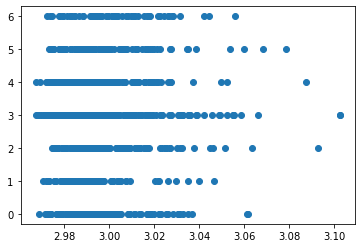

In [168]:
model.eval()
pred = model(data)
print(F.mse_loss(pred[data.test_mask], data.y[data.test_mask].float()))
pl.scatter(pred[data.test_mask].tolist(), data.y[data.test_mask].float().tolist())